# Решение NLP задачи классификации текстов от А до Я 

---


Материалы настоящего блокнота опираются на открытый курс компании Google, доступный по ссылке https://developers.google.com/machine-learning/guides/text-classification/.

Рабочий проект для анализа текста: https://github.com/google/eng-edu/tree/master/ml/guides/text_classification/

В настоящем блокноте приведено решение задачи бинарной классификации отзывов на фильмы(http://ai.stanford.edu/%7Eamaas/data/sentiment/aclImdb_v1.tar.gz) на позитивные и негативные.

Структурно блокнот имеет следующую последовательность тематических блоков:

0.    Введение. Постановка задачи.
1.   Сбор данных. Рекомендации.
2.   Изучение метрических характеристик данных. **Алгоритм действий** по подготовке исходных данных и выбору предсказательной модели.
3.   Подготовка исходных данных.
4.   Построение, обучение и оценка предсказательной модели.
5.   Настройка гиперпараметров.
      
6.   Заключение.



# 0. Введение. Постановка задачи.
В настоящем блокноте решается задача бинарной классификации текстов. Стоит задача предсказания интонации текста: позитивная или негативная. Последовательность действий при решении такого рода задач соответствует пунктам 1-5 настоящего блокнота. Схематично можно изобразить порядок действий как 

![alt text](https://developers.google.com/machine-learning/guides/text-classification/images/Workflow.png)

# 1. Сбор данных. Рекомендации

Сбор и анализ данных является одним из самых важных и трудоемких этапов. Для отработки навыков работы с текстами можно использовать готовые датасеты, которые уже хорошо обработаны. В рамках реальных задач сбор данных необходимо производить, опираясь на ряд общих рекомендаций:


*   Чем больше данных для обучения будет собрано, тем большей обобщающей способностью будет обладать ваша модель
*   Объеты каждого класса должны охватывать все многообразие объектов класса, а не быть только его специфически определенным подмножеством
*   Количество объектов в каждом классе должно быть сбалансированно. Для балансировки используются методы сэмплирования: искусственное дублирование наблюдений из редкого класса, исключение части наблюдений из популярного класса




# 2. Изучение метрических характеристик данных. **Алгоритм действий** по подготовке исходных данных и выбору предсказательной модели.

**Разархивирование исходных данных**

In [0]:
# Монтирование диска
from google.colab import drive
drive.mount('/content/drive')

# Разархивирование исходных данных
!tar xvzf ".../aclImdb_v1.tar.gz"

In [0]:
!ls

aclImdb  drive	sample_data


**Код для формирования обучающего и тестового набора**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the test data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))
  


**Формирование исходных данных**

In [0]:
(x_train, y_train),(x_test, y_test) = load_imdb_sentiment_analysis_dataset("", seed=123)

**Код полученияе метрических характеристик данных**

In [0]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 1),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
plt.show()

**Анализ исходных данных**

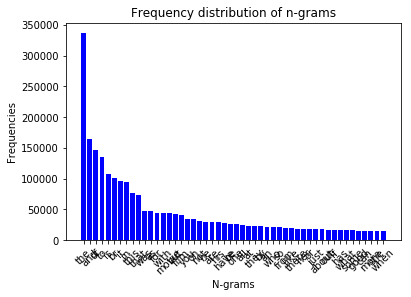

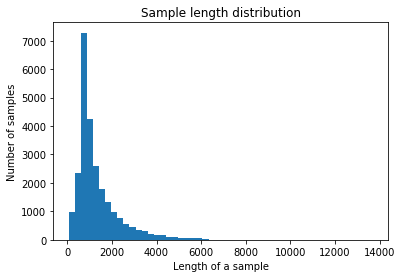

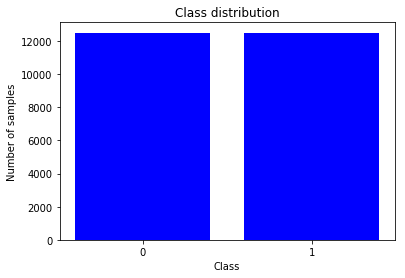

In [0]:
# Количество классов
num_classes = get_num_classes(y_train)

# Медианное значение количества слов на один объект(в данном случае Твит)
num_words_per_sample = get_num_words_per_sample(x_train)

# Распределение n-грамм по частоте встречаемости
plot_frequency_distribution_of_ngrams(x_train)

# Распределение количества символов в одном объекте
plot_sample_length_distribution(x_train)

# Распределение количества элементов каждого класса
plot_class_distribution(y_train)

# Алгоритм предобработки данных и выбора модели
Изображение алгоритма в виде блок-схемы:
![alt text](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)



> **Алгоритм**



1.    Подсчитывается отношение числа объектов в выборке(количество твитов) к медианному значению количества слов на один объект(число слов в одном твите).
2.    Если полученное отношение меньше , чем магическое число 1500, то выполняется движение по левой ветке алгоритма, то есть объекты разбиваются на n-граммы слов, токенизируются и ограничываются  20000 наиболее значимых значений, после чего применяется полносвязная нейронная сеть.
    
      2.1.   Слова разбиваются на n-граммы. После n-граммы представляются в виде векторов с использованием либо бинарного представления, либо частотного, либо с использованием  параметра tf-idf(частоты встречаемости характерных классу слов - общие слова для всех классов имеют низкий показатель)
      
      2.2.   Выбираются наиболее значимые для классификации n-граммы с использованием статистических показателей(корелляция каждого параметра со значением класса).
      
      2.3.   Данные нормализуются и идут на вход полносвязной нейронной сети.

3.   Если полученное отношение больше 1500, то выполняется правая ветка алгоритма, то есть тексты векторизуются и применяется сверточная нейронная сеть sepCNN.
    
      3.1.   Текст разбивается на слова. Выбирается 20000 наиболее часто встречаемых слов.
      
      3.2.   Объекты представляются в виде векторов последовательностей слов.
      
      3.3.   Если полученное на шаге 1 отношение меньше 15000, то выполняется предобученный embedding  и используется sepCNN.

4.   На последнем этапе подбираются оптимальные гиперпараметры используемых моделей.


Замечание. Зеленым цветом отмечены рекомендуемые шаги выполнения алгоритма, но всегда стоит попробовать повыбирать альтернативные варианты для шагов, отмеченные серым цветом,  например, использовать посимвольный анализ текста вместо анализа по словам. Стоит учитывать, что полносвязной и сверточной архитектурой в рамках конкретной задачи ограничиваться тоже не стоит!




# 3. Подготовка исходных данных.

Исходные данные - текстовая информация - необходимо представить на понятном машине языке, то есть преобразовать в последовательности чисел. Процесс преобразования строится в 2 этапа: **токенизация** и **векторизация**. 

В **алгоритме**, представленном в предыдушем параграфе существенным является то, что модели, которые используются для обработки данных согласно левой ветви, не используют информацию о порядке слов в исходных тестах, в отличие от моделей, лежащих в правой ветви. Если также обратить внимание на используемые в алгоритме модели, то сама их природа подсказывает **необходимость в разных подходах к представлению данных**, которые идут им на вход. 

*Пример токенизации и векторизации в случае алгоритмов левой ветви*:

Исходный текст: 'The mouse ran up the clock'

n-граммы: ['the', 'mouse', 'ran', 'up', 'clock'], ['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock', ... ]

Токены: {'the': 7, 'mouse': 2, 'ran': 4, 'up': 10,  'clock': 0, 'the mouse': 9, 'mouse ran': 3, 'ran up': 6, 'up the': 11, 'the clock': 8, 'down': 1, 'ran down': 5}

Векторизация one-hot-encoding: 'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]

Векторизация сount encoding: 'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1]

Векторизация Tf-Idf: 'The mouse ran up the clock' = [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33,
0.23, 0.33, 0.33]

Этап отбора самых значимых токенов осуществляется с использованием различных статистик, которые можно найти здесь https://scikit-learn.org/0.21/modules/feature_selection.html#univariate-feature-selection

*Пример токенизации и векторизации в случае алгоритмов правой ветви*:

Исходные тексты: 'The mouse ran up the clock' and 'The mouse ran down'

Токенизация на основе частоты встречаимости: {'clock': 5, 'ran': 3, 'up': 4, 'down': 6, 'the': 1, 'mouse': 2}. 

Токены (0 - зарезервирован для неизвестных токенов): 'The mouse ran up the clock' = [1, 2, 3, 4, 1, 5]

Векторизация one-hot-encoding: 

'The mouse ran up the clock' = [
  
  [0, 1, 0, 0, 0, 0, 0],
  
  [0, 0, 1, 0, 0, 0, 0],
  
  [0, 0, 0, 1, 0, 0, 0],
  
  [0, 0, 0, 0, 1, 0, 0],
  
  [0, 1, 0, 0, 0, 0, 0],
  
  [0, 0, 0, 0, 0, 1, 0]
]

Векторизация word embeddings:

![alt text](https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png)

Этап отбора самых значимых токенов - выбор наиболее часто встречаемых слов.

**Код для токенизации и векторизации данных, идущих по левой ветви алгоритма**

In [0]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val



**Код для токенизации и векторизации данных, идущих по правой ветви алгоритма**

In [0]:
###############################################################################  
###############################################################################
# Данная часть кода относится к правой ветви алгоритма. 
#                              Не используется!
###############################################################################  
###############################################################################  

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index
###############################################################################  
###############################################################################
# Данная часть кода относится к правой ветви алгоритма. 
#                              Не используется!
###############################################################################  
###############################################################################  


**Применение алгоритма к задаче классификации отзывов Imdb по интонации**

In [0]:
# Подсчет основного отношения, определяющего ход алгоритма 
COMMON_RATIO = len(x_train)/num_words_per_sample
print(int(COMMON_RATIO))

143


In [0]:
# Так как 143 < 1500, то идем по левой ветви алгоритма
x_train_vec, x_test_vec = ngram_vectorize(x_train,y_train, x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


# 4. Построение, обучение и оценка предсказательной модели.

**Код построения модели**

In [0]:
# Данные функции являются реализациями популярных моделей каждой ветви алгоритма
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

  
###############################################################################  
###############################################################################
# Данная часть кода относится к sepCNN - модели правой ветви алгоритма. 
#                              Не используется!
###############################################################################  
###############################################################################  
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model
###############################################################################  
###############################################################################
# Данная часть кода относится к sepCNN - модели правой ветви алгоритма. 
#                              Не используется!
###############################################################################  
###############################################################################  


**Код создания сети и обучения на подготовленных данных**

In [0]:
# Данная функция создает и обучает модель
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=5,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Not Vectorize texts !!!
    x_train, x_val = train_texts, val_texts #ngram_vectorize(train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

**Запуск модели**

In [0]:
data = ((x_train_vec, y_train),(x_test_vec, y_test))

val_acc,val_loss = train_ngram_model(data,epochs=10)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 - 12s - loss: 0.4695 - acc: 0.8628 - val_loss: 0.3227 - val_acc: 0.8862
Epoch 2/10
25000/25000 - 12s - loss: 0.2334 - acc: 0.9208 - val_loss: 0.2512 - val_acc: 0.9014
Epoch 3/10
25000/25000 - 12s - loss: 0.1687 - acc: 0.9407 - val_loss: 0.2337 - val_acc: 0.9066
Epoch 4/10
25000/25000 - 12s - loss: 0.1350 - acc: 0.9542 - val_loss: 0.2303 - val_acc: 0.9068
Epoch 5/10
25000/25000 - 12s - loss: 0.1110 - acc: 0.9646 - val_loss: 0.2332 - val_acc: 0.9043
Epoch 6/10
25000/25000 - 12s - loss: 0.0931 - acc: 0.9705 - val_loss: 0.2393 - val_acc: 0.9027
Validation accuracy: 0.9027199745178223, loss: 0.23926945679187775


# 5. Настройка гиперпараметров.

**Код подбора параметров и отрисовки графика**

In [0]:
# Реализация подбора параметров в модели левой ветви алгоритма
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

FLAGS = None


def tune_ngram_model(data):
    """Tunes n-gram model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
    """
    # Select parameter values to try.
    num_layers = [1, 2, 3]
    num_units = [8, 16, 32]

    # Save parameter combination and results.
    params = {
        'layers': [],
        'units': [],
        'accuracy': [],
    }

    # Iterate over all parameter combinations.
    for layers in num_layers:
        for units in num_units:
                params['layers'].append(layers)
                params['units'].append(units)

                accuracy, _ = train_ngram_model(
                    data=data,
                    layers=layers,
                    units=units)
                print(('Accuracy: {accuracy}, Parameters: (layers={layers}, '
                       'units={units})').format(accuracy=accuracy,
                                                layers=layers,
                                                units=units))
                params['accuracy'].append(accuracy)
    _plot_parameters(params)


def _plot_parameters(params):
    """Creates a 3D surface plot of given parameters.
    # Arguments
        params: dict, contains layers, units and accuracy value combinations.
    """
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(params['layers'],
                    params['units'],
                    params['accuracy'],
                    cmap=cm.coolwarm,
                    antialiased=False)
plt.show()

**Подбор параметров и отрисовка графика**

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 - 8s - loss: 0.6692 - acc: 0.7968 - val_loss: 0.6489 - val_acc: 0.8472
Epoch 2/5
25000/25000 - 8s - loss: 0.6230 - acc: 0.8764 - val_loss: 0.6105 - val_acc: 0.8525
Epoch 3/5
25000/25000 - 8s - loss: 0.5833 - acc: 0.8784 - val_loss: 0.5777 - val_acc: 0.8561
Epoch 4/5
25000/25000 - 8s - loss: 0.5491 - acc: 0.8822 - val_loss: 0.5494 - val_acc: 0.8597
Epoch 5/5
25000/25000 - 8s - loss: 0.5195 - acc: 0.8860 - val_loss: 0.5247 - val_acc: 0.8621
Validation accuracy: 0.8620799779891968, loss: 0.5247091780090332
Accuracy: 0.8620799779891968, Parameters: (layers=1, units=8)
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 - 8s - loss: 0.6686 - acc: 0.8404 - val_loss: 0.6481 - val_acc: 0.8483
Epoch 2/5
25000/25000 - 8s - loss: 0.6222 - acc: 0.8771 - val_loss: 0.6098 - val_acc: 0.8508
Epoch 3/5
25000/25000 - 8s - loss: 0.5825 - acc: 0.8812 - val_loss: 0.5769 - val_acc: 0.8562
Epoch 4/5
25000/25000 - 8s -

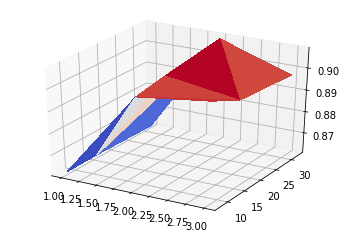

In [0]:
tune_ngram_model(data)

# 6. Заключение.
Классификация текста - это фундаментальная задача машинного обучения, возникающая в различных областях. В этом руководстве процесс классификации текста разбит на несколько этапов. Для каждого этапа предложен индивидуальный подход, основанный на характеристиках конкретного набора данных. В частности, используя отношение количества объектов в выборке к медианному значению числа слов в выборке предлагается использование определенного типа модели, базавая реализация которого приводит к достаточно хорошим показателям аккуратности классификации. Однако это только хороший базовый этап - получение наилучшей модели требует глубокой проработки данных и настройки модели.